## Equal Risk Pricing of Financial Derivatives with Deep Hedging 
This notebook presents an example of implementation of the equal risk pricing framework as presented in Carbonneau and Godin (2020). 
- The equal risk option price $C_{0}^{\star}$ and the measure of market incompleteness $\epsilon^{\star}$ are computed for a European-type put option of maturity 60 days under the Black-Scholes model. 
- The deep hedging algorithm of Buehler et al. (2019) is applied twice to train two distinct neural networks which are used to approximate the optimal hedging strategy respectively for the long and the short position in the derivative.
- The convex risk measure used to measure the risk of each counterparty is the Conditional Value-at-Risk with alpha = 0.95. 
- For a complete description of the algorithm, the reader is referred to section 3 of Carbonneau and Godin (2020). 

Important note: some parts of the code are inspired by the following implementation of the deep hedging algorithm: 
    - https://github.com/mgroncki/DataScienceNotebooks/blob/master/DeepHedging/DeepHedging_Part1.ipynb  
    - https://nbviewer.jupyter.org/urls/people.math.ethz.ch/~jteichma/lecture_ml_web/lecture_3.ipynb

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import tensorflow as tf
import random
import datetime as dt
import matplotlib.pyplot as plt

### 1) Construction of the train and test sets
- A) Simulation of 500K paths under the Black-Scholes model with the parameters [sigma, mu] = [0.1952, 0.0892] on a yearly scale. 
    - The feature vector for this model is $X_{n} = [\log(S_{n}/K), V_{n}, T-t_{n}]$ where $V_{n}$ is the hedging portfolio value. The log-moneyness transformation of the stock price was found to improve the learning of neural networks.  
- B) Split into train and test sets with 400K and 100K paths.

In [2]:
# Parameters
[sigma, mu]  = [0.1952, 0.0892] # Yearly parameters
S_0          = 100     # Initial stock price
strike       = 100     # Strike price
T            = 60/260  # Time-to-maturity of the vanilla put option
n_sims       = 500000  # Total number of paths to simulate
n_timesteps  = 60      # Daily hedging
r            = 0.02    # Annualized continuous risk-free rate

# Simulation of BSM dataset 
seed           = 10
h              = T / n_timesteps  # step-size
Price_mat      = np.zeros((n_timesteps+1, n_sims))  # matrix of simulated stock prices 
Price_mat[0,:] = S_0
for i in range(n_sims):
    rand_stdnorm     = np.random.randn(n_timesteps)
    Price_mat[1:,i]  = S_0 * np.cumprod(np.exp((mu-sigma**2/2)*h+sigma*np.sqrt(h)*rand_stdnorm))

# Apply a transformation to stock prices
prepro_stock = "Log-moneyness"  # {Log, Log-moneyness, Nothing}
if(prepro_stock == "Log"):
    Price_mat = np.log(Price_mat)
elif(prepro_stock == "Log-moneyness"):
    Price_mat = np.log(Price_mat/strike)

# Construct the train and test sets
# - The feature vector for now is [S_n, T-t_n]; the portfolio value V_{n} will be added further into the code at each time-step
train_input     = np.zeros((n_timesteps+1, 400000,2))
test_input      = np.zeros((n_timesteps+1, 100000,2))
time_to_mat     = np.zeros(n_timesteps+1)
time_to_mat[1:] = T / (n_timesteps)      # [0,h,h,h,..,h]                     
time_to_mat     = np.cumsum(time_to_mat) # [0,h,2h,...,Nh]
time_to_mat     = time_to_mat[::-1]      # [Nh, (N-1)h,...,h,0]

train_input[:,:,0] = Price_mat[:,0:400000]  
train_input[:,:,1] = np.reshape(np.repeat(time_to_mat, train_input.shape[1], axis=0), (n_timesteps+1, train_input.shape[1]))
test_input[:,:,0]  = Price_mat[:,400000:]
test_input[:,:,1]  = np.reshape(np.repeat(time_to_mat, test_input.shape[1], axis=0), (n_timesteps+1, test_input.shape[1]))

### 2) Hyperparameters of neural networks as in Section 4.1.2 of the paper and the risk aversion parameter

In [3]:
batch_size    = 1000   # batch size
epochs        = 100    # number of epochs
hidden_layers = 2      # number of hidden layers (output layer not included, for a total of three layers)
nbs_units     = 56     # neurons per layer
lr            = 0.0005 # learning rate of the Adam optimizer
alpha         = 0.95   # confidence level of the CVaR risk measure

### 3) Tensor of discount factors
- disc_mat: (n_timesteps+1 x n_sims x 1) tensor of cumulative discount rates (discount from t to 0), i.e. $\exp(-rh*n)$ 
    - Will be split into disc_mat_train and disc_mat_test for convenience

In [4]:
disc_mat              = np.zeros((n_timesteps+1, 500000, 1))
disc_train            = np.zeros((n_timesteps+1, 400000, 1))
disc_test             = np.zeros((n_timesteps+1, 100000, 1))
discount_vect         = np.ones(disc_mat.shape[0])   
h                     = T / n_timesteps
discount_vect[1:]     = np.exp(-r*h)              # [1,exp(-rh), exp(-rh),....,exp(-rh)]
discount_vect         = np.cumprod(discount_vect) # [1,exp(-rh), exp(-r2h),....,exp(-rNh)]
disc_mat              = np.reshape(np.repeat(discount_vect, 500000), (n_timesteps+1, 500000,1))
disc_train            = disc_mat[:,0:400000,:]
disc_batch            = disc_mat[:,0:batch_size,:]  # for convenience when only batch-size is needed
disc_test             = disc_mat[:,400000:,:]
disc_mat              = []  

### 4) Deep hedging class
- This class implements the deep hedging algorithm of Buehler et al. (2019) with a feedforward neural network as described in section 3.3 of Carbonneau and Godin (2020). 

In [5]:
class DeepAgent(object):
    """
    Inputs:
    nbs_point_traj: if [S_0,...,S_N] ---> nbs_point_traj = N+1
    batch_size    : size of mini-batch
    nbs_input     : number of features (always 2 in this example)
    position_type : {Long, Short}
    hidden_layers : number of hidden layers (doesn't include the output layer) 
    nbs_units     : number of neurons per layer
    lr            : learning rate hyperparameter of the Adam optimizer
    prepro_stock  : {Log, Log-moneyness, Nothing} - what transformation was used for stock prices
    name          : name to load the trained neural network once trained
    """
    def __init__(self, nbs_point_traj, batch_size, nbs_input, position_type, hidden_layers, nbs_units, lr, prepro_stock, name):
    
        tf.reset_default_graph() 
        self.nbs_point_traj = nbs_point_traj
        self.batch_size     = batch_size
        self.nbs_input      = nbs_input
        self.position_type  = position_type
        self.hidden_layers  = hidden_layers
        self.nbs_units      = nbs_units
        self.lr             = lr        
        self.prepro_stock   = prepro_stock
            
        # 1) Placeholder
        self.input        = tf.placeholder(tf.float32, [nbs_point_traj, batch_size, nbs_input])  # Stock prices are normalized here
        self.strike       = tf.placeholder(tf.float32, batch_size)                    
        self.alpha        = tf.placeholder(tf.float32)   # Risk aversion parameter of CVaR risk measure
        self.disc_tensor  = tf.placeholder(tf.float32, [nbs_point_traj, batch_size, 1]) # To discount from 't' to 0.
        self.deltas       = tf.zeros(shape = [nbs_point_traj-1, batch_size, 1], dtype=tf.float32)
        
        # 2) Discount prices computation:
        self.unorm_price = self.inverse_processing(self.input[:,:,0], prepro_stock)   # Inverse normalization
        discount_price   = tf.multiply(self.unorm_price, self.disc_tensor[:,:,0])     # exp(-rh*n)*S_{n}  
        inc_disc_ret     = discount_price[1:,:] - discount_price[0:-1,:]              # Increment of discount returns
        
        # 3) Payoff of each path for an ATM put option
        self.payoff = tf.maximum(self.strike - self.unorm_price[-1,:],0)

        # 4) Compute the deltas of the strategy with the deep hedging algorithm
        # 4.1) Two hidden layers with relu activation function
        layer_1 = tf.layers.Dense(self.nbs_units, tf.nn.relu)
        layer_2 = tf.layers.Dense(self.nbs_units, tf.nn.relu)
        
        # 4.2) Output layer of dimension one (outputs the position in the underlying)
        layer_out = tf.layers.Dense(1, None)
           
        # 4.3) Compute hedging strategies for all time-steps        
        V_t = tf.zeros(self.batch_size)  # initial portfolio value is always zero
        for t in range(self.nbs_point_traj-1):                

            # input of the FFNN at time 't': [S_t, T-t, V_t]
            input_t = tf.concat([self.input[t,:,:], tf.expand_dims(V_t, axis = 1)], axis=1)   

            # forward prop at time 't'
            layer = layer_1(input_t)
            layer = layer_2(layer)
            layer = layer_out(layer)
                    
            # Compile the trading strategies
            if (t==0):
                # At t = 0, need to expand the dimension to have [nbs_point_traj, batch_size, 1]
                self.deltas = tf.expand_dims(layer,axis=0)      # [1, batch_size, 1]

            else:
                self.deltas = tf.concat([self.deltas, tf.expand_dims(layer, axis = 0)], axis = 0)
                
            # Compute the portoflio value for the next period   
            factor  = tf.div(self.disc_tensor[t,:,0], self.disc_tensor[t+1,:,0]) # equals exp(rh)
            V_t_pre = V_t
            # Update rule from Godin (2016), see eq. (1)
            V_t     = V_t_pre*factor + self.deltas[t,:,0]*(self.unorm_price[t+1,:] - self.unorm_price[t,:]*factor)
 
        
        # 5) Compute the discounted gain at maturity for each paths 
        cumulative_factor  = tf.reciprocal(self.disc_tensor[-1,:,0])                 # Project from 0 to T
        self.disc_gain     = tf.reduce_sum(inc_disc_ret*self.deltas[:,:,0], axis=0)  # G_{N}
        
        # 6) Compute hedging errors for each paths as if initial portfolio value is zero
        if(self.position_type == 'Short'):
            self.hedging_err = self.payoff - cumulative_factor*self.disc_gain
        elif(self.position_type == 'Long'):
            self.hedging_err = - self.payoff - cumulative_factor*self.disc_gain
        
        # 7) Compute the CVaR_{alpha} on the batch of hedging error
        # - This is the empirical cost functions estimated with a mini-batch
        # - Equivalent to estimator of CVaR_{alpha} presented in the paper of Carbonneau and Godin (2020) 
        #   since alpha*N_{batch} is an integer in this example
        self.loss = tf.reduce_mean(tf.contrib.framework.sort(self.hedging_err)[tf.cast(self.alpha*self.batch_size,tf.int32):])
        
        # 8) SGD step with the adam optimizer
        optimizer  = tf.train.AdamOptimizer(learning_rate = lr)  
        self.train = optimizer.minimize(self.loss) 
        
        # 9) Save the model
        self.saver      = tf.train.Saver()
        self.model_name = name   # name of the neural network to save
          
    # Function to compute the CVaR_{alpha} outside the optimization, i.e. at the end of each epoch in this case
    def loss_out_optim(self, hedging_err, alpha):
        loss = np.mean(np.sort(hedging_err)[int(alpha*hedging_err.shape[0]):])
        return loss
    
    # Given a type of preprocessing, reverse the processing of the stock price
    def inverse_processing(self, paths, prepro_stock):
        if (prepro_stock =="Log-moneyness"):
            paths = tf.multiply(self.strike, tf.exp(paths))
        elif (prepro_stock == "Log"):
            paths = tf.exp(paths)
        return paths
    
    # ---------------------------------------------------------------------------------------# 
    # Function to call the deep hedging algorithm batch-wise
    # Disclore: function adapted from https://github.com/mgroncki/DataScienceNotebooks/blob/master/DeepHedging/DeepHedging_Part1.ipynb 
    """
    Input:
     - paths       : tensor of features of dimension [n_timesteps+1, n_sims, nbs_features]
     - strikes     : vector of strike prices of dimension [N_batch]
     - disc_batch  : tensor of discount factors of dimension [n_timesteps+1, N_batch, 1]
     - alpha       : level of risk aversion of the hedger
     - epochs      : total number of epochs to run
    """
    def train_deephedging(self, paths, strikes, disc_batch, alpha, sess, epochs):
        sample_size       = paths.shape[1]               # total number of paths in the train set
        batch_size        = self.batch_size    
        idx               = np.arange(sample_size)       # [0,1,...,sample_size-1]
        start             = dt.datetime.now()            # Time-to-train
        self.loss_epochs  = 9999999*np.ones(epochs)      # Store the loss at the end of each epoch for the train              
        epoch             = 0                       
        
        # Loop for each epoch until the maximum number of epochs
        while (epoch < epochs):
            hedging_err_train = []  # Store hedging errors obtained for one complete epoch 
            np.random.shuffle(idx)  # Randomize the dataset (not useful in this case since dataset is simulated iid)
            
            # loop over each batch size
            for i in range(int(sample_size/batch_size)):
                
                # Indexes of paths used for the mini-batch
                indices = idx[i*batch_size : (i+1)*batch_size]
                                
                # SGD step 
                _, hedging_err = sess.run([self.train, self.hedging_err], 
                                               {self.input        : paths[:,indices,:],
                                                self.strike       : strikes,
                                                self.alpha        : alpha,
                                                self.disc_tensor  : disc_batch})
            
                hedging_err_train.append(hedging_err)
            
            # Store the loss on the train set after each epoch for learning curve
            self.loss_epochs[epoch] = self.loss_out_optim(np.concatenate(hedging_err_train), alpha)
            
            # Print the CVaR value at the end of each epoch
            print('Time elapsed:', dt.datetime.now()-start)
            print('Epoch %d, CVaR - Train: %.3f' % (epoch+1, self.loss_epochs[epoch]))
                
            epoch+=1  # increment the epoch
                
        # End of training
        print("---Finished training results---")
        print('Time elapsed:', dt.datetime.now()-start)    
        self.saver.save(sess, r"/Users/alexa/ERP paper example/Models/%s/models.ckpt" % self.model_name)
  
        # Return the learning curve 
        return self.loss_epochs

    # Function which will call the deep hedging optimization batchwise
    def training(self, paths, strikes, disc_batch, riskaversion, sess, epochs):
        sess.run(tf.global_variables_initializer()) 
        loss_train_epoch = self.train_deephedging(paths, strikes, disc_batch, riskaversion, sess, epochs)
        return loss_train_epoch

    # ---------------------------------------------------------------------- #
    # Function to compute the hedging strategies of a trained neural network
    # - Doesn't train the neural network, only outputs the hedging strategies
    def predict(self, paths, strikes, disc_paths, alpha, sess):
        sample_size = paths.shape[1]
        batch_size  = self.batch_size    
        idx         = np.arange(sample_size)  # [0,1,...,sample_size-1]
        start       = dt.datetime.now()     # compute time
        strategy_pred = [] # hedging strategies
            
        # loop over sample size to do one complete epoch
        for i in range(int(sample_size/batch_size)):
                
            # mini-batch of paths (even if not training to not get memory issue)
            indices = idx[i*batch_size : (i+1)*batch_size]  
            _, strategy = sess.run([self.hedging_err, self.deltas], 
                                    {self.input        : paths[:,indices,:],
                                     self.strike       : strikes,
                                     self.alpha        : alpha, 
                                     self.disc_tensor  : disc_paths})
            
            # Append the batch of hedging strategies
            strategy_pred.append(strategy)
        return np.concatenate(strategy_pred,axis=1) 
    
    def restore(self, sess, checkpoint):
        self.saver.restore(sess, checkpoint)

### 5) Function to compute the measured risk exposure given a sample of paths and hedging decisions

In [6]:
#-------------------------------------------------------------------------------------------------#
#---------------      Functions to evaluate the measured risk exposure       ---------------------#
#-------------------------------------------------------------------------------------------------#
""" 
Input:
- deltas       : (time step x nbs of paths) 
- paths        : (time step x nbs of paths)  
- disc_paths   : (time step x nbs of paths x 1)
- alpha        : for the CVaR computation
- position_type: {Long, Short}
- prepro_stock : {Log, Log-moneyness, Nothing} - what transformation was used for stock prices
"""
#-------------------------------------------------------------------------------------------------#
def measured_risk_exposures(deltas, paths, disc_paths, strike, position_type, prepro_stock):
    
    # De-normalize the stock price process
    if(prepro_stock == "Log"):
        paths = np.exp(paths)
    elif(prepro_stock == "Log-moneyness"):
        paths = strike*np.exp(paths)
        
    # Discounted prices and returns for each paths at each timesteps
    discount_price    = np.multiply(paths, disc_paths[:,:,0])          # exp(-rh*n)*S_{n} 
    inc_disc_ret      = discount_price[1:,:] - discount_price[0:-1,:]  # Increment of discount returns
    
    # Option payoff of vanilla ATM put
    option_payoff     = np.maximum(strike - paths[-1,:],0) 
    
    # Discounted gain process
    disc_gain         = np.sum(deltas*inc_disc_ret, axis = 0)  # G_{N}
    cumulative_factor = np.reciprocal(disc_paths[-1,:,0])      # B_{N}
     
    if(position_type == 'Short'):
        hedging_err = option_payoff - cumulative_factor*disc_gain
    elif(position_type == 'Long'):
        hedging_err = - option_payoff - cumulative_factor*disc_gain
        
    # Empirical CVaR at level alpha
    loss = np.mean(np.sort(hedging_err)[int(alpha*hedging_err.shape[0]):]) 
    
    return loss

### 6) Training of the short neural network and computation of the short measured risk exposure $\epsilon^{(S)}(0)$. 

Hyperparameters: learning rate=0.0005, layers=2, neurons=56
---Training start---
Time elapsed: 0:00:15.943601
Epoch 1, CVaR - Train: 8.010
Time elapsed: 0:00:29.229584
Epoch 2, CVaR - Train: 4.640
Time elapsed: 0:00:42.430549
Epoch 3, CVaR - Train: 4.527
Time elapsed: 0:00:55.699528
Epoch 4, CVaR - Train: 4.498
Time elapsed: 0:01:09.069530
Epoch 5, CVaR - Train: 4.482
Time elapsed: 0:01:22.399524
Epoch 6, CVaR - Train: 4.458
Time elapsed: 0:01:35.651491
Epoch 7, CVaR - Train: 4.442
Time elapsed: 0:01:48.930472
Epoch 8, CVaR - Train: 4.408
Time elapsed: 0:02:02.417500
Epoch 9, CVaR - Train: 4.408
Time elapsed: 0:02:15.671486
Epoch 10, CVaR - Train: 4.389
Time elapsed: 0:02:28.965471
Epoch 11, CVaR - Train: 4.379
Time elapsed: 0:02:42.260456
Epoch 12, CVaR - Train: 4.371
Time elapsed: 0:02:55.531436
Epoch 13, CVaR - Train: 4.361
Time elapsed: 0:03:08.866430
Epoch 14, CVaR - Train: 4.363
Time elapsed: 0:03:22.125407
Epoch 15, CVaR - Train: 4.356
Time elapsed: 0:03:35.306359
Epoch 16, CVaR

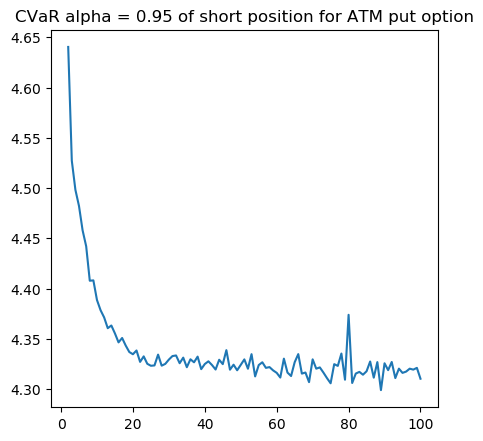

INFO:tensorflow:Restoring parameters from /Users/alexa/ERP paper example/Models/Short_FFNN/models.ckpt
Measured risk exposure of short position on train set: 4.2838
Measured risk exposure of short position on test set: 4.2991


In [7]:
position_type = 'Short'
model_name    = "Short_FFNN"
print("Hyperparameters: learning rate=%.4f, layers=%d, neurons=%d" %(lr, hidden_layers, nbs_units))

# Compile the neural network
FFNN_short = DeepAgent(train_input.shape[0], batch_size, train_input.shape[2], position_type, hidden_layers, 
                        nbs_units, lr, prepro_stock, model_name)
    
# Start training 
start = dt.datetime.now()
print('---Training start---')
with tf.Session() as sess:
    loss_train_epoch = FFNN_short.training(train_input, np.ones(batch_size)*strike, disc_batch, alpha, sess, epochs)
   
    print('---Training end---')

# Plot the learning curve on the train set, i.e. the CVaR on the train set at the end of each epoch
lin_nb_epoch = np.linspace(1, loss_train_epoch.shape[0], loss_train_epoch.shape[0])
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(lin_nb_epoch[1:], loss_train_epoch[1:])
plt.title('CVaR alpha = 0.95 of short position for ATM put option')
plt.show()

# Compute measured risk exposure on train and valid set
model_predict = DeepAgent(test_input.shape[0], batch_size, test_input.shape[2], position_type, hidden_layers, 
                          nbs_units, lr, prepro_stock, model_name)

with tf.Session() as sess:
    
    # Load the saved model
    model_predict.restore(sess, r"/Users/alexa/ERP paper example/Models/%s/models.ckpt" % model_name)
    
    # Compute hedging strategies on the training set
    deltas = model_predict.predict(train_input, np.ones(batch_size)*strike, disc_batch, alpha, sess)
    
    # Compute CVaR 95% on the train set
    CVaR_95_short_train =  measured_risk_exposures(deltas[:,:,0], train_input[:,:,0], disc_train, strike, position_type, prepro_stock)
  
    # Compute hedging strategies on the test set
    deltas = model_predict.predict(test_input, np.ones(batch_size)*strike, disc_batch, alpha, sess)
        
    # Compute CVaR 95% on the test set
    CVaR_95_short_test   = measured_risk_exposures(deltas[:,:,0], test_input[:,:,0], disc_test, 
                            strike, position_type, prepro_stock)
    print("Measured risk exposure of short position on train set: %.4f" %(CVaR_95_short_train))
    print("Measured risk exposure of short position on test set: %.4f" %(CVaR_95_short_test))

### 7) Training of the long neural network and computation of the long measured risk exposure $\epsilon^{(L)}(0)$. 

Hyperparameters: learning rate=0.0005, layers=2, neurons=56
---Training start---
Time elapsed: 0:00:15.242431
Epoch 1, CVaR - Train: -0.155
Time elapsed: 0:00:28.030303
Epoch 2, CVaR - Train: -2.599
Time elapsed: 0:00:40.925199
Epoch 3, CVaR - Train: -2.647
Time elapsed: 0:00:53.801090
Epoch 4, CVaR - Train: -2.676
Time elapsed: 0:01:06.638972
Epoch 5, CVaR - Train: -2.690
Time elapsed: 0:01:19.526866
Epoch 6, CVaR - Train: -2.705
Time elapsed: 0:01:32.398757
Epoch 7, CVaR - Train: -2.721
Time elapsed: 0:01:45.245634
Epoch 8, CVaR - Train: -2.725
Time elapsed: 0:01:58.044515
Epoch 9, CVaR - Train: -2.724
Time elapsed: 0:02:10.810382
Epoch 10, CVaR - Train: -2.732
Time elapsed: 0:02:23.532238
Epoch 11, CVaR - Train: -2.734
Time elapsed: 0:02:36.326102
Epoch 12, CVaR - Train: -2.734
Time elapsed: 0:02:49.151991
Epoch 13, CVaR - Train: -2.752
Time elapsed: 0:03:02.009878
Epoch 14, CVaR - Train: -2.744
Time elapsed: 0:03:14.854763
Epoch 15, CVaR - Train: -2.748
Time elapsed: 0:03:27.698647

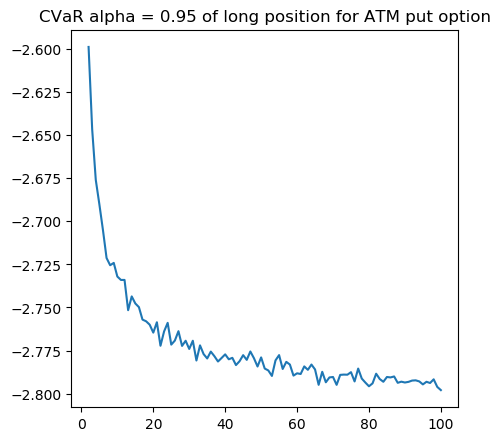

INFO:tensorflow:Restoring parameters from /Users/alexa/ERP paper example/Models/Long_FFNN/models.ckpt
Measured risk exposure of long position on train set: -2.8113
Measured risk exposure of long position on test set: -2.8119


In [8]:
position_type = 'Long'
model_name    = "Long_FFNN"
print("Hyperparameters: learning rate=%.4f, layers=%d, neurons=%d" %(lr, hidden_layers, nbs_units))

# Compile the neural network
FFNN_long = DeepAgent(train_input.shape[0], batch_size, train_input.shape[2], position_type, hidden_layers, 
                        nbs_units, lr, prepro_stock, model_name)
    
# Start training 
start = dt.datetime.now()
print('---Training start---')
with tf.Session() as sess:
    loss_train_epoch = FFNN_long.training(train_input, np.ones(batch_size)*strike, disc_batch, alpha, sess, epochs)
   
    print('---Training end---')
    
# Plot the learning curve on the train set, i.e. the CVaR on the train set at the end of each epoch
lin_nb_epoch = np.linspace(1, loss_train_epoch.shape[0], loss_train_epoch.shape[0])
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(lin_nb_epoch[1:], loss_train_epoch[1:])
plt.title('CVaR alpha = 0.95 of long position for ATM put option')
plt.show()

# Compute measured risk exposure on train and valid set
model_predict = DeepAgent(test_input.shape[0], batch_size, test_input.shape[2], position_type, hidden_layers, 
                          nbs_units, lr, prepro_stock, model_name)

with tf.Session() as sess:
    
    # Load the saved model
    model_predict.restore(sess, r"/Users/alexa/ERP paper example/Models/%s/models.ckpt" % model_name)

    # Compute hedging strategies on the training set
    deltas = model_predict.predict(train_input, np.ones(batch_size)*strike, disc_batch, alpha, sess)
    
    # Compute CVaR 95% on the train set
    CVaR_95_long_train =  measured_risk_exposures(deltas[:,:,0], train_input[:,:,0], disc_train, strike, position_type, prepro_stock)
  
    # Compute hedging strategies on the test set
    deltas = model_predict.predict(test_input, np.ones(batch_size)*strike, disc_batch, alpha, sess)
        
    # Compute CVaR 9% on the test set
    CVaR_95_long_test   = measured_risk_exposures(deltas[:,:,0], test_input[:,:,0], disc_test, 
                            strike, position_type, prepro_stock)
    print("Measured risk exposure of long position on train set: %.4f" %(CVaR_95_long_train))
    print("Measured risk exposure of long position on test set: %.4f" %(CVaR_95_long_test))

### 8) Compute equal risk option prices $C_{0}^{\star}$ and incompleteness measure $\epsilon^{\star}$ with the results of the test set:
$$C_{0}^{\star} = \frac{\epsilon^{(S)}(0) - \epsilon^{(L)}(0)}{2B_{N}},$$
$$\epsilon^{\star} = \frac{\epsilon^{(L)}(0) + \epsilon^{(S)}(0)}{2}.$$

In [13]:
ERP     = (CVaR_95_short_test - CVaR_95_long_test)/(2*np.exp(r*T))
epsilon = (CVaR_95_long_test + CVaR_95_short_test)/2
print("Equal risk price of ATM put of 60 days: %.4f" %(ERP))
print("Residual hedging risk of ATM put of 60 days: %.4f" %(epsilon))

Equal risk price of ATM put of 60 days: 3.5392
Residual hedging risk of ATM put of 60 days: 0.7436


References
- Buehler, H., Gonon, L., Teichmann, J., and Wood, B. (2019b). Deep hedging. Quantitative Finance, 19(8):1271-1291.
- Carbonneau, A. and Godin, F. (2020). Equal risk option pricing with deep reinforcement learning. arXiv preprint arXiv:2002.08492.
- Godin, F. (2016). Minimizing CVaR in global dynamic hedging with transaction costs. Quantitative Finance, 16(3):461-475.